In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df1 = pd.read_csv('format_stack.csv')

non_zero_columns = df1.loc[:, (df1 != 0).any(axis=0)]
st_languages = [col for col in non_zero_columns.columns if col != 'year']  

df=df1['Python']

In [3]:
model = pm.auto_arima(df, seasonal=False, stepwise=True, trace=True)

print(f"Best p: {model.order[0]}")
print(f"Best d: {model.order[1]}")
print(f"Best q: {model.order[2]}")

p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.020, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=138.822, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=140.680, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=140.718, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=139.557, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.816 seconds
Best p: 1
Best d: 0
Best q: 0


In [4]:
df = df.dropna()
df = df.astype(float)

arima_model = ARIMA(df, order=(p,d,q))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Python   No. Observations:                   11
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -66.779
Date:                Thu, 14 Nov 2024   AIC                            139.557
Time:                        23:31:09   BIC                            140.751
Sample:                             0   HQIC                           138.805
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        214.5106    134.509      1.595      0.111     -49.122     478.143
ar.L1          0.8297      0.243      3.415      0.001       0.353       1.306
sigma2      9872.4620   4254.912      2.320      0.0

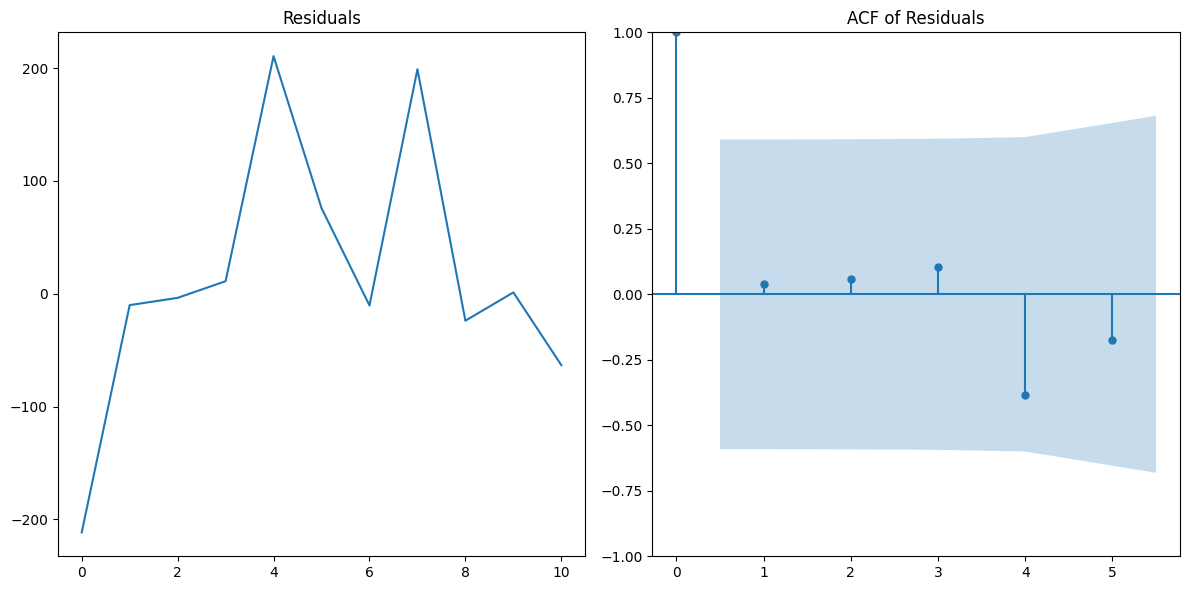

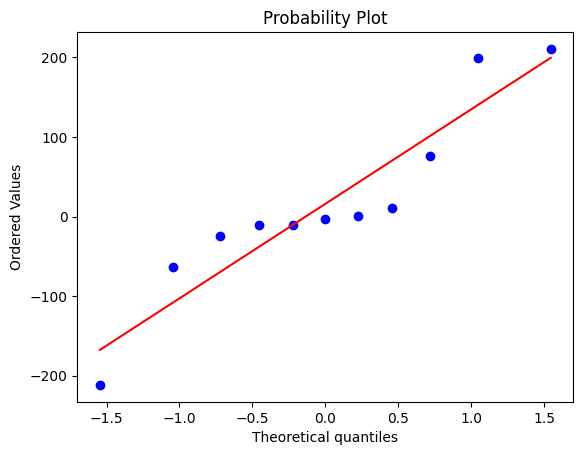

In [5]:
residuals = model.resid
plt.figure(figsize=(12, 6))

# Residual plot
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')

# ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()


In [6]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

arima_model = ARIMA(train, order=(1,1,1))
model = arima_model.fit()

forecast = model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 183.14449708863467, MSE: 36376.242826030386, RMSE: 190.7255694080644


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


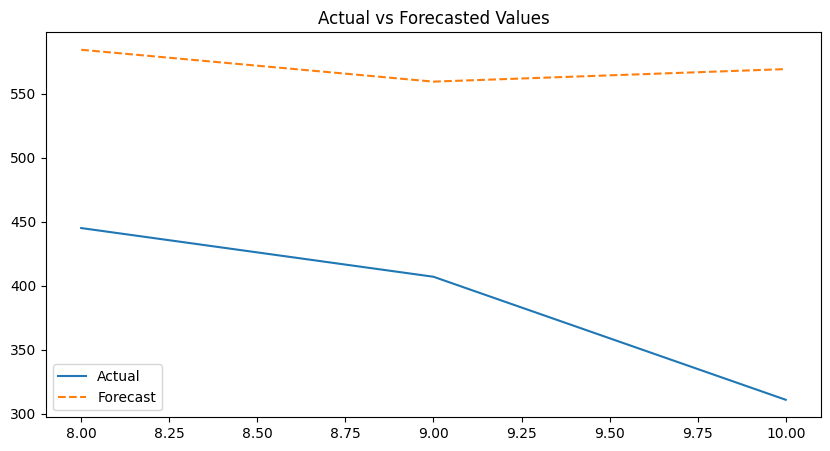

In [7]:
# Plotting actual vs. forecasted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.show()


In [15]:
di = {}
di['language'] = []
di['mae'] = []
di['mse'] = []
di['rmse'] = []


for language in st_languages:
    df = df1[language]  # Select language data from the main DataFrame

    # Set up time series cross-validation with 10 splits
    tscv = TimeSeriesSplit(n_splits=5)
    
    fold_mae = []
    fold_mse = []
    fold_rmse = []

    # Iterate over each train/test split in TimeSeriesSplit
    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Skip fold if training data is insufficient
        if len(train) < 2:
            print(f"Skipping fold due to insufficient data for {language}")
            continue

        # Fit ARIMA model with auto order selection
        model = pm.auto_arima(train, seasonal=False, stepwise=True, trace=False)
        p, d, q = model.order
        
        try:
            arima_model = ARIMA(train, order=(p, d, q))
            model = arima_model.fit()
        except ValueError:
            arima_model = ARIMA(train, order=(1, 1, 1))
            model = arima_model.fit()

        # Forecast future values
        forecast = model.forecast(steps=len(test)).ravel()

        # Check if forecast and test sizes match
        if len(forecast) != len(test):
            print(f"Skipping fold due to mismatched forecast and test lengths for {language}")
            continue

        # Calculate metrics
        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)

        # Append metrics to fold lists
        fold_mae.append(mae)
        fold_mse.append(mse)
        fold_rmse.append(rmse)

    # Calculate average metrics for each language
    avg_mae = np.mean(fold_mae)
    avg_mse = np.mean(fold_mse)
    avg_rmse = np.mean(fold_rmse)

    print(f'Language: {language}')
    print(f"Average MAE: {avg_mae}, Average MSE: {avg_mse}, Average RMSE: {avg_rmse}")
    print()

    # Store results in the dictionary
    di['language'].append(language)
    di['mae'].append(avg_mae)
    di['mse'].append(avg_mse)
    di['rmse'].append(avg_rmse)

# Convert results to a DataFrame and save as CSV
df_res = pd.DataFrame.from_dict(di)
df_res.to_csv('result_arima.csv', index=False)


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series i

Language: APL
Average MAE: 6.174545646094264, Average MSE: 50.539902604221936, Average RMSE: 6.174545646094264



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: ASP.NET
Average MAE: 41.29160380193041, Average MSE: 2772.464304935849, Average RMSE: 41.29160380193041



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARM

Language: Ada
Average MAE: 4.90000497693737, Average MSE: 63.05005017589978, Average RMSE: 4.90000497693737



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

Language: Apex
Average MAE: 3.420004841395419, Average MSE: 29.322033272764806, Average RMSE: 3.420004841395419



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Arduino
Average MAE: 4.5147224567676645, Average MSE: 22.589973625578054, Average RMSE: 4.5147224567676645



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Us

Language: Assembly
Average MAE: 11.73758008284868, Average MSE: 197.93293406320623, Average RMSE: 11.73758008284868



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Bash
Average MAE: 70.91849142166016, Average MSE: 5902.832803319987, Average RMSE: 70.91849142166016



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: C
Average MAE: 23.649302664576542, Average MSE: 938.4416769714823, Average RMSE: 23.649302664576542



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: C#
Average MAE: 41.70340067079332, Average MSE: 3084.234132079519, Average RMSE: 41.70340067079332



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: C++
Average MAE: 39.15125927784377, Average MSE: 3516.490236731695, Average RMSE: 39.15125927784377



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Us

Language: Crystal
Average MAE: 5.714357160379191, Average MSE: 44.334307141954085, Average RMSE: 5.714357160379191



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy arra

Language: DYNAMO
Average MAE: 17.50000483724985, Average MSE: 816.2501696845187, Average RMSE: 17.50000483724985



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel i

Language: Dart
Average MAE: 55.120018058385405, Average MSE: 5584.629638123193, Average RMSE: 55.120018058385405



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Delphi
Average MAE: 19.939103363640676, Average MSE: 598.9782500198659, Average RMSE: 19.939103363640676



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Elixir
Average MAE: 17.992164263838113, Average MSE: 408.7077472030125, Average RMSE: 17.992164263838113



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel i

Language: Erlang
Average MAE: 13.265598623394169, Average MSE: 250.97935127567325, Average RMSE: 13.265598623394169



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: F#
Average MAE: 7.512138938411073, Average MSE: 99.04014292889835, Average RMSE: 7.512138938411073



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy arra

Language: Flow
Average MAE: 1.7600028640990417, Average MSE: 12.928013845733725, Average RMSE: 1.7600028640990417



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Go
Average MAE: 33.41175643648653, Average MSE: 2494.911617360046, Average RMSE: 33.41175643648653



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Groovy
Average MAE: 8.74809820224733, Average MSE: 94.19544298471615, Average RMSE: 8.74809820224733



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Haskell
Average MAE: 8.587860077476803, Average MSE: 108.86581355824926, Average RMSE: 8.587860077476803



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Java
Average MAE: 51.055422860623665, Average MSE: 3918.9285159472793, Average RMSE: 51.055422860623665



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: JavaScript
Average MAE: 117.54898822661369, Average MSE: 31474.749987561507, Average RMSE: 117.54898822661369



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Kotlin
Average MAE: 18.716241374020065, Average MSE: 782.4481756267244, Average RMSE: 18.716241374020065



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()


Language: Lisp
Average MAE: 4.4000058161100934, Average MSE: 48.80006625339589, Average RMSE: 4.4000058161100934



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Lua
Average MAE: 21.581190872450644, Average MSE: 613.1393884558446, Average RMSE: 21.581190872450644



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: MATLAB
Average MAE: 16.357701506132095, Average MSE: 312.71406225674235, Average RMSE: 16.357701506132095



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: MariaDB
Average MAE: 54.220477686004344, Average MSE: 6771.1418310447525, Average RMSE: 54.220477686004344



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: MySQL
Average MAE: 126.5441349447711, Average MSE: 41449.79343045285, Average RMSE: 126.5441349447711



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Node.js
Average MAE: 227.50262304371017, Average MSE: 65080.918378211, Average RMSE: 227.50262304371017



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: PHP
Average MAE: 71.14158921173228, Average MSE: 9197.931673728646, Average RMSE: 71.14158921173228



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Perl
Average MAE: 5.3142867220700705, Average MSE: 85.00979464763984, Average RMSE: 5.3142867220700705



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary. 

Language: PostgreSQL
Average MAE: 99.90806114383273, Average MSE: 24460.599769044253, Average RMSE: 99.90806114383273



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()


Language: PowerShell
Average MAE: 30.435650797546373, Average MSE: 1436.2072227003132, Average RMSE: 30.435650797546373



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Python
Average MAE: 66.19207498031197, Average MSE: 10149.648749730684, Average RMSE: 66.19207498031197



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: R
Average MAE: 6.836073670092114, Average MSE: 109.58721097163398, Average RMSE: 6.836073670092114



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Ruby
Average MAE: 13.947775193179126, Average MSE: 243.3539539594921, Average RMSE: 13.947775193179126



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel i

Language: Rust
Average MAE: 42.930377230785524, Average MSE: 2073.7074342354977, Average RMSE: 42.930377230785524



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

Language: SAS
Average MAE: 4.053754682423514, Average MSE: 27.575593547375252, Average RMSE: 4.053754682423514



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: SPARK
Average MAE: 8.005868052801313, Average MSE: 66.23713026886072, Average RMSE: 8.005868052801313



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: SQL
Average MAE: 72.9743795036609, Average MSE: 13577.723149153917, Average RMSE: 72.9743795036609



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel i

Language: SQLite
Average MAE: 71.44755473796293, Average MSE: 8522.061055878698, Average RMSE: 71.44755473796293



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Scala
Average MAE: 2.187619382992401, Average MSE: 6.222412683875676, Average RMSE: 2.187619382992401



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()


Language: Solidity
Average MAE: 11.64706865182286, Average MSE: 259.84400065726135, Average RMSE: 11.64706865182286



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Swift
Average MAE: 9.858046064788699, Average MSE: 184.21946549224714, Average RMSE: 9.858046064788699



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fa

Language: TypeScript
Average MAE: 92.05040736859341, Average MSE: 16058.76055449261, Average RMSE: 92.05040736859341



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

Language: VBA
Average MAE: 11.120161326344322, Average MSE: 153.0853761507721, Average RMSE: 11.120161326344322



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so rave

Language: Visual Basic
Average MAE: 34.864280826997415, Average MSE: 1256.1631804214626, Average RMSE: 34.864280826997415



C:\Users\asus\AppData\Local\Temp\ipykernel_21688\18405124.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  forecast = model.forecast(steps=len(test)).ravel()
